In [133]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from sklearn.preprocessing import StandardScaler
import time

In [134]:
M = np.load('li_N10_k2_reducedm.npy')
y = np.load('syntheticEnergies.npy')

rand_state = np.random.RandomState(10)
basis_ind = np.arange(M.shape[1])
reverse_ind = basis_ind[::-1]
# rand_state.shuffle(basis_ind)
# shuffled_ind = basis_ind


In [135]:
M.shape

(2346, 2346)

In [136]:
# scaler = StandardScaler()
# M_scaled = scaler.fit_transform(M)

ctrue, _, _, _ = np.linalg.lstsq(M, y, rcond=None)
d = 20
M = M[:, reverse_ind]
M_modeled = M[:,:d]

In [137]:
print(f"Shape of design matrix M: {M.shape}")

nsims = 15
max_samples = 700

# Start with enough samples to ensure the matrix is likely full rank
nstart = 5

Shape of design matrix M: (2346, 2346)


In [138]:
def run_simulation(samples, overhead_time, probs=None, nstart=50):
    if probs is None:
        # Uniform probability for random sampling
        probs = np.ones_like(samples, dtype=float)

    assert probs.size == samples.size

    res = {'chat': [], 'errs': [], 'MTMinv_norm':[], 'c_err': [], 'runtime':[]}
    T = samples[:nstart]

    start_time = time.perf_counter()
    for i in range(samples.size - nstart + 1):
        MTM = M_modeled[T, :]
        yT = y[T]
        
        probsi = np.sqrt(probs[:nstart+i] * (nstart+i))
        
        # Solve the least squares problem on the sampled subset
        chat = np.linalg.lstsq(MTM / probsi.reshape(-1, 1), yT / probsi, rcond=None)[0]
        
        # Calculate error against the full-dataset model's predictions
        res['chat'].append(chat)
        res['errs'].append(np.linalg.norm(y - M_modeled @ chat))
        # res['c_err'].append(np.linalg.norm(ctrue - chat))
        try: 
            Minv = np.linalg.pinv(MTM)
            res['MTMinv_norm'].append(norm(Minv,ord=2))

        except np.linalg.LinAlgError:
            res['MTMinv_norm'].append(np.nan)
        
        T = samples[:nstart+i+1]
        res['runtime'].append(time.perf_counter() - start_time + overhead_time)
    return res


In [140]:
RESULTS_RAND = []
print("\nRunning Random Sampling Simulations...")
for j in range(nsims):
    start_time = time.perf_counter() 
    rand_state = np.random.RandomState(42 + j)
    samples = np.arange(M_modeled.shape[0])
    rand_state.shuffle(samples)
    samples = samples[:max_samples]
    
    uniform_probs_on_samples = np.ones_like(samples, dtype=float) / M_modeled.shape[0]
    RESULTS_RAND.append(run_simulation(samples, time.perf_counter() - start_time, uniform_probs_on_samples, nstart=nstart))
    print(f"Finished simulation {j+1}/{nsims}")



Running Random Sampling Simulations...
Finished simulation 1/15
Finished simulation 2/15
Finished simulation 3/15
Finished simulation 4/15
Finished simulation 5/15
Finished simulation 6/15
Finished simulation 7/15
Finished simulation 8/15
Finished simulation 9/15
Finished simulation 10/15
Finished simulation 11/15
Finished simulation 12/15
Finished simulation 13/15
Finished simulation 14/15
Finished simulation 15/15


In [117]:
# --- Leverage Score Sampling Simulations ---
start_time = time.perf_counter()
Q, _ = np.linalg.qr(M_modeled)
leverage_scores = np.linalg.norm(Q, axis=1)**2

# Normalize to get sampling probabilities
ls_probs = leverage_scores / leverage_scores.sum()

RESULTS_LS = []
overhead_time = time.perf_counter() - start_time
print("\nRunning Leverage Score Sampling Simulations...")

for j in range(nsims):
    rand_state = np.random.RandomState(42 + j)
    # Sample without replacement using the leverage score probabilities
    ls_samples = rand_state.choice(M_modeled.shape[0], max_samples, p=ls_probs, replace=True)
    ls_probs_on_samples = ls_probs[ls_samples]
    RESULTS_LS.append(run_simulation(ls_samples, overhead_time, ls_probs_on_samples, nstart=nstart))
    print(f"  Finished simulation {j+1}/{nsims}")



Running Leverage Score Sampling Simulations...
  Finished simulation 1/15
  Finished simulation 2/15
  Finished simulation 3/15
  Finished simulation 4/15
  Finished simulation 5/15
  Finished simulation 6/15
  Finished simulation 7/15
  Finished simulation 8/15
  Finished simulation 9/15
  Finished simulation 10/15
  Finished simulation 11/15
  Finished simulation 12/15
  Finished simulation 13/15
  Finished simulation 14/15
  Finished simulation 15/15


In [118]:
from tqdm import tqdm

In [119]:
def leverage_scores_bernoulli_trials_simulation(X,y,log_interval):
    Q, _ = np.linalg.qr(X)
    lev_scores = np.linalg.norm(Q, axis=1)**2

    trials_by_count = {n:{'chat': [], 'errs': []} for n in range(nstart, max_samples+1)}
    total_trial_slots = len(trials_by_count.keys())
    simulation_num = 0

    n_target = nstart
    alpha = 0.01
    while n_target <= max_samples:
        while len(trials_by_count[n_target]['errs']) < nsims:
            simulation_num += 1
            if simulation_num % log_interval == 0:
                print(f" Simulation Run: {simulation_num} Populated Trials out of Total Trial Slots: {n_target-nstart}/{total_trial_slots}")
            
            probs = np.clip(lev_scores * alpha, 0, 1)
            row_bernoulli_trials = np.random.binomial(1, probs)

            n = np.sum(row_bernoulli_trials)
            if n < n_target:
                alpha *= 1.02
                continue
            elif n > n_target:
                alpha *= 0.98
                continue

            selected_rows = X[row_bernoulli_trials == 1, :]

            selected_rows_probs = probs[row_bernoulli_trials == 1]

            y_sampled = y[row_bernoulli_trials]

            probsi = np.sqrt(selected_rows_probs * n).reshape(-1,1)


            chat = np.linalg.lstsq(selected_rows / probsi, y_sampled / probsi, rcond=None)[0]
            
            trials_by_count[n]['chat'].append(chat)
            trials_by_count[n]['errs'].append(np.linalg.norm(y - M_modeled @ chat))
        
        n_target += 1
            
    return trials_by_count
            

In [120]:
def convert_bernoulli_results(trials_by_count, nstart, max_samples):
    results_list = []

    num_trials_per_n = max(len(trials_by_count[n]['errs']) for n in range(nstart, max_samples+1))

    for trial_idx in range(num_trials_per_n):
        trial_dict = {'errs': [], 'chat':[]}

        for n in range(nstart, max_samples+1):

            for key in trial_dict.keys():
                values = trials_by_count[n][key]
                if trial_idx < len(values):
                    trial_dict[key].append(values[trial_idx])
                else:
                    trial_dict[key].append(np.nan)

        results_list.append(trial_dict)

    return results_list

In [121]:
RESULTS_LS_BERNOULLI = leverage_scores_bernoulli_trials_simulation(M_modeled, y, 1000)


 Simulation Run: 1000 Populated Trials out of Total Trial Slots: 7/696
 Simulation Run: 2000 Populated Trials out of Total Trial Slots: 14/696
 Simulation Run: 3000 Populated Trials out of Total Trial Slots: 20/696
 Simulation Run: 4000 Populated Trials out of Total Trial Slots: 25/696
 Simulation Run: 5000 Populated Trials out of Total Trial Slots: 30/696
 Simulation Run: 6000 Populated Trials out of Total Trial Slots: 34/696
 Simulation Run: 7000 Populated Trials out of Total Trial Slots: 38/696
 Simulation Run: 8000 Populated Trials out of Total Trial Slots: 41/696
 Simulation Run: 9000 Populated Trials out of Total Trial Slots: 45/696
 Simulation Run: 10000 Populated Trials out of Total Trial Slots: 50/696
 Simulation Run: 11000 Populated Trials out of Total Trial Slots: 54/696
 Simulation Run: 12000 Populated Trials out of Total Trial Slots: 57/696
 Simulation Run: 13000 Populated Trials out of Total Trial Slots: 60/696
 Simulation Run: 14000 Populated Trials out of Total Trial Sl

Text(0, 0.5, 'Error')

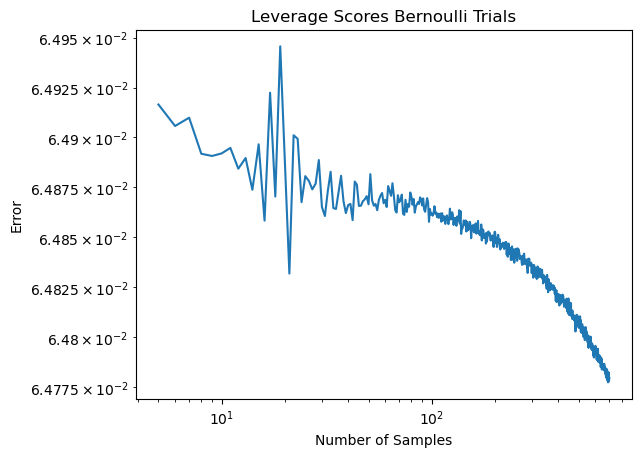

In [150]:

bernoulli_errs = [np.mean(RESULTS_LS_BERNOULLI[n]['errs']) / M_modeled.shape[0] for n in range(nstart,max_samples+1)]
plt.loglog(np.arange(nstart,max_samples+1), bernoulli_errs)
plt.title("Leverage Scores Bernoulli Trials")
plt.xlabel("Number of Samples")
plt.ylabel("Error")

In [130]:
RESULTS_LS_BERNOULLI_FORMATTED = convert_bernoulli_results(RESULTS_LS_BERNOULLI, nstart, max_samples)

In [131]:
np.sum(leverage_scores), np.sum(ls_probs)

(np.float64(19.999999999999986), np.float64(1.0))

In [125]:
start_time = time.perf_counter()
Q_full, _ = np.linalg.qr(M)
leverage_scores_full = np.linalg.norm(Q, axis=1)**2

# Normalize to get sampling probabilities
ls_probs_full = leverage_scores_full / leverage_scores_full.sum()

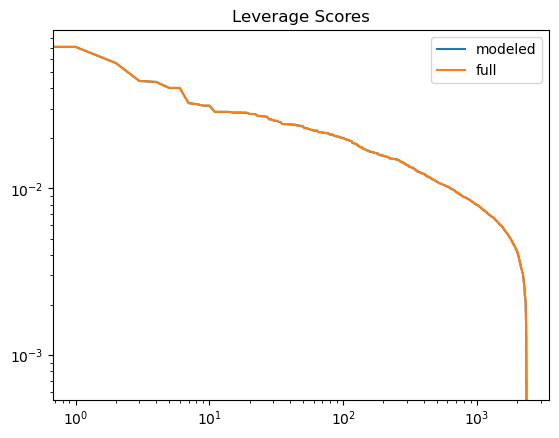

In [126]:
plt.loglog(sorted(leverage_scores, reverse=True), label='modeled')
plt.loglog(sorted(leverage_scores_full, reverse=True), label='full')
plt.legend()
plt.title("Leverage Scores")
plt.savefig("figures/cluster_expansion/leverage_scores")

In [127]:
from optimal_design_sub_mod import run_simulation_greedy_sub_mod

RESULTS_OD_SUB_MOD_A = [run_simulation_greedy_sub_mod(M_modeled, y, np.arange(d), ctrue[:d], nstart, max_samples, "A")[0]]
RESULTS_OD_SUB_MOD_V = [run_simulation_greedy_sub_mod(M_modeled, y, np.arange(d), ctrue[:d], nstart, max_samples, "V")[0]]

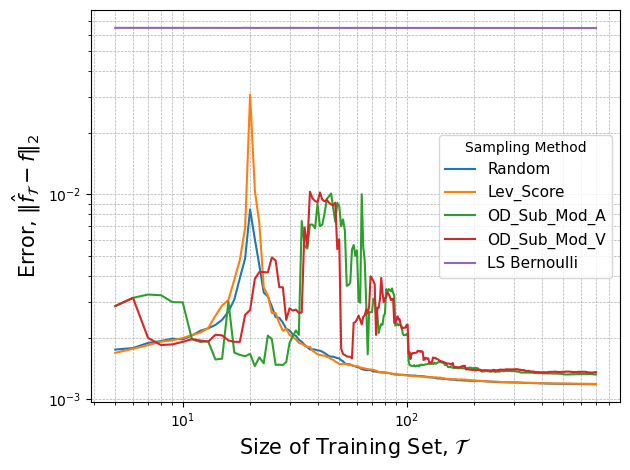

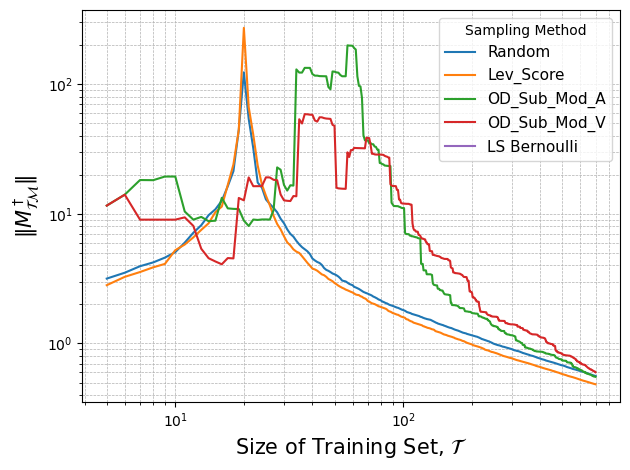

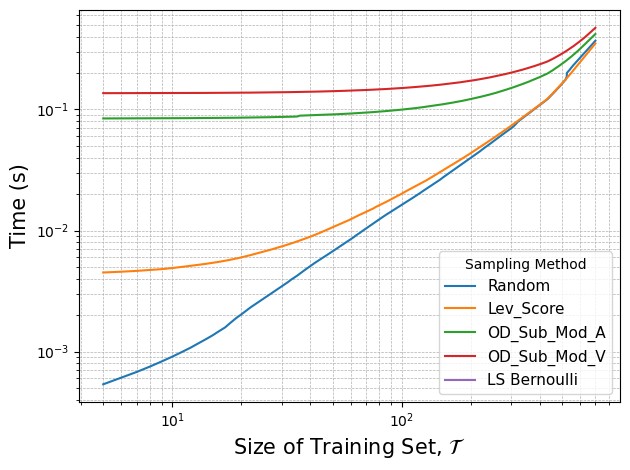

In [132]:
import os
max_to_plot = max_samples 
min_to_plot = 5
save = True

keys = ['errs', 'MTMinv_norm', 'runtime']
for key in keys:
    if key == 'errs':
        ylabel = r"Error, $\|\hat{f}_{\mathcal{T}} - f\|_2$" 
    # elif key == 'A_norm':
    #     ylabel = r"$\|A\|$"
    elif key == 'MTMinv_norm':
        ylabel = r"$\|M_{\mathcal{TM}}^\dagger\|$"
    elif key == 'c_err':
        ylabel = r"$\|c - \hat{c}\|$"
    elif key == 'runtime':
        ylabel = 'Time (s)'

    savename = f"{key.lower()}_cluster_expansion_reversed.png"
    fig, ax = plt.subplots()
    for results, name in zip([RESULTS_RAND, RESULTS_LS, RESULTS_OD_SUB_MOD_A, RESULTS_OD_SUB_MOD_V, RESULTS_LS_BERNOULLI_FORMATTED], ['Random', 'Lev_Score', 'OD_Sub_Mod_A', 'OD_Sub_Mod_V', 'LS Bernoulli']):
        metric = np.array([res[key] for res in results])
        if key == 'errs':
            metric /= M_modeled.shape[0]
        mean = metric.mean(axis=0)
        # std = metric.std(axis=0)
        
        l = ax.loglog(np.arange(nstart, len(mean) + nstart), mean, label=name, linestyle='-')


        # ax.fill_between(np.arange(nstart, len(mean) + nstart), mean, mean + std, color=l[0].get_color(), alpha=0.5 )
        # for err in errs:
        #     ax.plot(np.arange(nstart, len(mean) + nstart), err, alpha=0.25, color=l[0].get_color())


    ax.legend(title='Sampling Method', fontsize=11)
    ax.set_xlabel(r"Size of Training Set, $\mathcal{T}$", fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)

    ax.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    if save:
        outdir = f"figures/cluster_expansion"
        os.makedirs(outdir, exist_ok=True)
        plt.savefig(f"{outdir}/{savename}", dpi=250, format='png')

KeyboardInterrupt: 

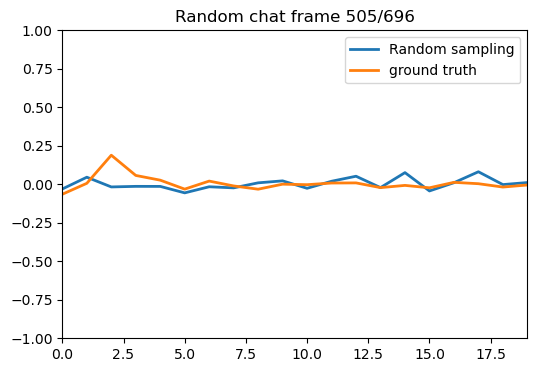

In [11]:
# chat's over time
from matplotlib.animation import FuncAnimation, PillowWriter
import os
ctrue_observed = ctrue[:d]
for results, name in zip([RESULTS_RAND, RESULTS_LS, RESULTS_OD_SUB_MOD_A, RESULTS_OD_SUB_MOD_V], ['Random', 'Lev_score', 'OD_Sub_Mod_A', 'OD_Sub_Mod_V']):
    data = np.array(results[0]['chat'])
    
    n_frames, n_points = data.shape
    x = np.arange(n_points)

    fig, ax = plt.subplots(figsize=(6, 4))
    line_approx, = ax.plot([], [], lw=2, label=f"{name} sampling")
    line_ground_truth, = ax.plot([],[],lw=2, label="ground truth")

    ax.set_xlim(0, n_points - 1)
    ax.set_ylim(-1, 1)
    ax.set_title(f"{name} chat")

    ax.legend()

    def init():
        line_approx.set_data([], [])
        line_ground_truth.set_data([], [])
        return line_approx, line_ground_truth

    def update(frame):
        line_approx.set_data(x, data[frame])
        line_ground_truth.set_data(x, ctrue_observed)
        ax.set_title(f"{name} chat frame {frame+1}/{n_frames}")
        return line_approx, line_ground_truth

    ani = FuncAnimation(fig, update, frames=n_frames,
                        init_func=init, blit=False, interval=10)

    writer = PillowWriter(fps=30)
    outdir = f"figures/cluster_expansion/{name.lower()}"
    os.makedirs(outdir, exist_ok=True)
    ani.save(f"{outdir}/chat_evolution_{name.lower()}.gif", writer=writer)